## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'spaceNet-full' 
TRANSFORM = 'wavelet-horizVert'
CHANNEL = 'gray'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
gray_horizVert_wavelet_full_spaceNet.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/spaceNet/full/wavelet/horizVert/gray'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 27208,
 3: 108832,
 4: 333298,
 5: 1149538,
 6: 4251250,
 7: 17005000,
 8: 68020000,
 9: 272080000}

Running 12760 CDFs


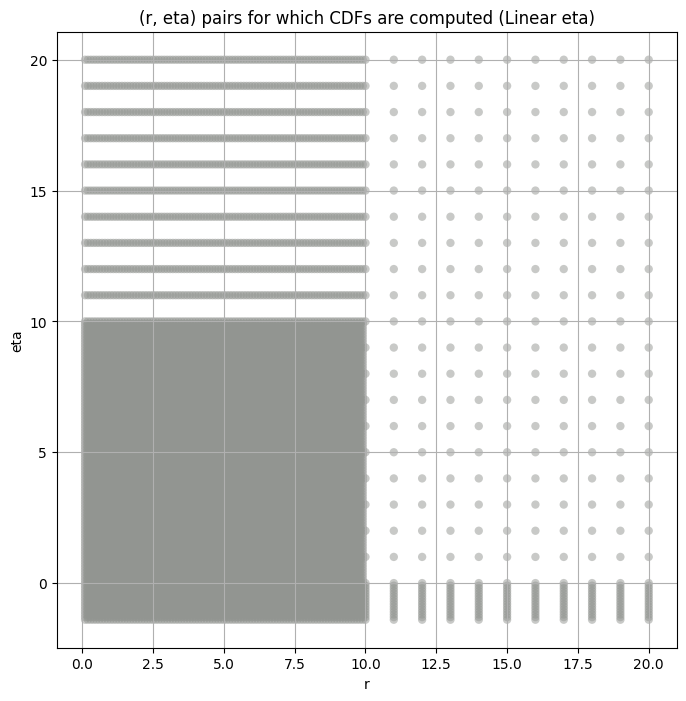

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.1, -1.4), <scipy.interpolate._fitpack2.Int...",0.1,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.628800e+06,554265.000000
1,"((0.1, -1.3), <scipy.interpolate._fitpack2.Int...",0.1,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.991680e+07,96192.272727
2,"((0.1, -1.2), <scipy.interpolate._fitpack2.Int...",0.1,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,2.395008e+08,29390.000000
3,"((0.1, -1.1), <scipy.interpolate._fitpack2.Int...",0.1,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.037837e+09,11997.692308
4,"((0.1, -1.0), <scipy.interpolate._fitpack2.Int...",0.1,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.632429e+09,5874.890110


In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
layer,,,,,,,
2,18678.723000,17502.768000,19935.713000,4.316421,2.884981,6.461045,27208.0
3,5005.067000,4561.687500,5522.817000,11.798066,6.478199,25.282856,108832.0
4,1581.170400,1451.115400,1726.020000,9.157448,6.194863,16.083818,333298.0
5,447.849730,409.950100,492.390620,10.531361,6.367925,30.655203,1149538.0
6,107.282080,98.076140,117.777664,10.588803,6.835792,22.530120,4251250.0
7,23.563640,21.139654,26.704834,18.381596,9.488063,58.651060,17005000.0
8,5.004115,4.364922,6.038305,36.424423,13.383648,160.152300,68020000.0
9,0.926162,0.778725,1.294118,103.429955,15.216067,467.548800,272080000.0


## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

,obs_var,var_exclude_0,var_exclude_25,var_exclude_50,var_exclude_75,var_exclude_100,var_exclude_150,var_exclude_200,var_exclude_250,var_exclude_300,var_exclude_350,var_exclude_500
layer,,,,,,,,,,,,
2,18678.723000,18678.722656,17565.822266,16957.363281,16471.984375,16041.399414,15295.384766,14656.140625,14094.216797,13593.180664,13134.925781,11956.498047
3,5005.067000,5005.066895,4770.616211,4658.637207,4570.674316,4493.984375,4361.878418,4248.308594,4147.141602,4055.496582,3971.172852,3752.007080
4,1581.170400,1581.170410,1521.702881,1487.661865,1460.018311,1436.246460,1395.214111,1359.589233,1327.850098,1298.910645,1272.230469,1202.585083
5,447.849730,447.849731,430.672821,421.089294,413.169342,406.257599,394.323120,384.022797,374.831604,366.502625,358.859741,338.832062
6,107.282080,107.282082,102.993637,100.544815,98.537506,96.799011,93.830811,91.294739,89.047012,87.010094,85.140244,80.257423
7,23.563640,23.563641,22.282089,21.620451,21.091352,20.639252,19.873951,19.226952,18.660006,18.151539,17.688038,16.492636
8,5.004115,5.004115,4.623251,4.445938,4.307835,4.191811,3.999552,3.840830,3.703885,3.582713,3.473665,3.197922
9,0.926162,0.926162,0.822474,0.786426,0.759263,0.736853,0.700378,0.670793,0.645614,0.623558,0.603860,0.554632


In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05
layer,,,,,,,,,,,,,,
2,18678.723000,17502.768000,19935.713000,4.316421,2.884981,6.461045,27208.0,0.012731,9.8,-1.0,5.310859e+04,50.0,16957.363000,0.008227
3,5005.067000,4561.687500,5522.817000,11.798066,6.478199,25.282856,108832.0,0.132400,1.4,-1.2,2.040830e+04,0.0,5005.067000,0.004115
4,1581.170400,1451.115400,1726.020000,9.157448,6.194863,16.083818,333298.0,0.077070,1.4,-1.2,6.447267e+03,0.0,1581.170400,0.002352
5,447.849730,409.950100,492.390620,10.531361,6.367925,30.655203,1149538.0,0.042100,6.0,-1.3,2.873397e+03,0.0,447.849730,0.001267
6,107.282080,98.076140,117.777664,10.588803,6.835792,22.530120,4251250.0,0.013962,1.1,-1.2,3.843363e+02,0.0,107.282080,0.000659
7,23.563640,21.139654,26.704834,18.381596,9.488063,58.651060,17005000.0,0.012999,1.0,-1.2,7.427363e+01,25.0,22.282090,0.000329
8,5.004115,4.364922,6.038305,36.424423,13.383648,160.152300,68020000.0,0.009947,0.3,-0.9,1.152098e-01,25.0,4.623251,0.000165
9,0.926162,0.778725,1.294118,103.429955,15.216067,467.548800,272080000.0,0.006903,0.1,1.2,8.525931e-16,50.0,0.786426,0.000082


## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/63 [00:00<?, ?it/s]

Finding Minimum after computing 63 CDFs
layer 2, 50.0 + 100 = 150, ksstat: 0.019180036081254848, var: 15295.384765625


  0%|          | 0/63 [00:00<?, ?it/s]

Finding Minimum after computing 63 CDFs
layer 2, 50.0 + 75 = 125, ksstat: 0.01753083395569721, var: 15652.0888671875


  0%|          | 0/63 [00:00<?, ?it/s]

Finding Minimum after computing 63 CDFs
layer 2, 50.0 + 50 = 100, ksstat: 0.015780684638035725, var: 16041.3994140625


  0%|          | 0/63 [00:00<?, ?it/s]

Finding Minimum after computing 63 CDFs
layer 2, 50.0 + 25 = 75, ksstat: 0.013929042991197793, var: 16471.984375


  0%|          | 0/63 [00:00<?, ?it/s]

Finding Minimum after computing 63 CDFs
layer 2, 50.0 + 0 = 50, ksstat: 0.012730996947021012, var: 16957.36328125


  0%|          | 0/63 [00:00<?, ?it/s]

Finding Minimum after computing 63 CDFs
layer 2, 50.0 + -25 = 25, ksstat: 0.01319684680302785, var: 17565.822265625


  0%|          | 0/63 [00:00<?, ?it/s]

Finding Minimum after computing 63 CDFs
layer 2, 50.0 + -50 = 0, ksstat: 0.014014434590787384, var: 18678.72265625
Number of samples: 27208, Without approximation : 27208.0


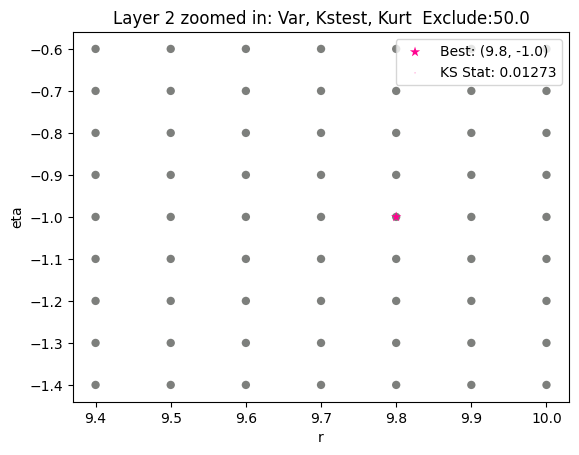

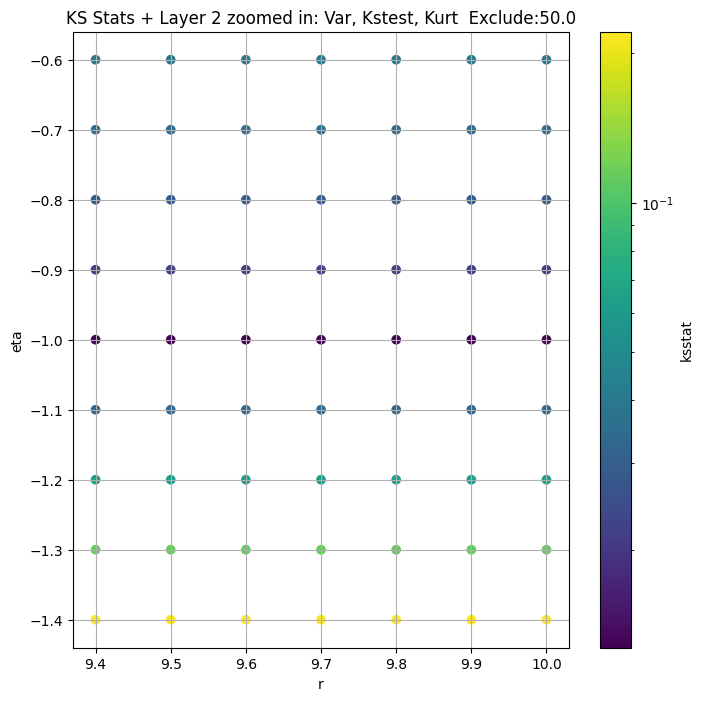

Layer 3


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.13239999999999974, var: 4493.984375


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.13239999999999974, var: 4570.67431640625


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.13239999999999974, var: 4658.63720703125


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.13239999999999974, var: 4770.6162109375


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.13239999999999974, var: 5005.06689453125
Number of samples: 100000, Without approximation : 108832.0


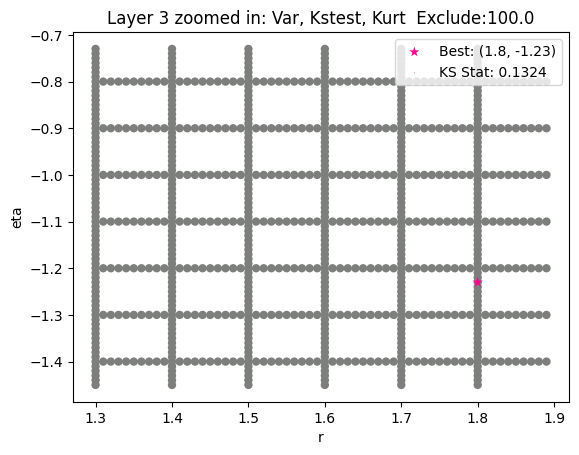

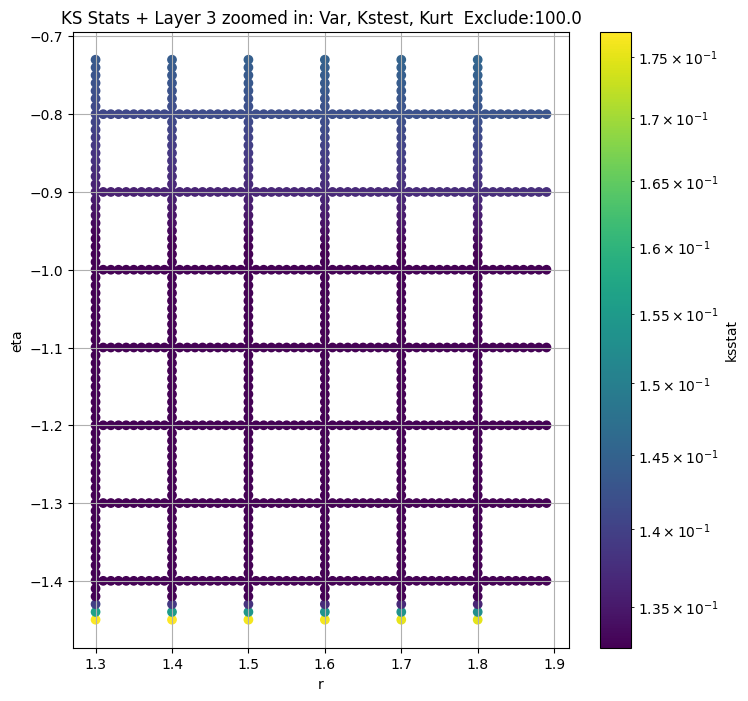

Layer 4


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.07706999999999975, var: 1436.2464599609375


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.07706999999999975, var: 1460.018310546875


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.07706999999999975, var: 1487.661865234375


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.07706999999999975, var: 1521.702880859375


  0%|          | 0/1380 [00:00<?, ?it/s]

Finding Minimum after computing 1380 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.07706999999999975, var: 1581.17041015625
Number of samples: 100000, Without approximation : 333298.0


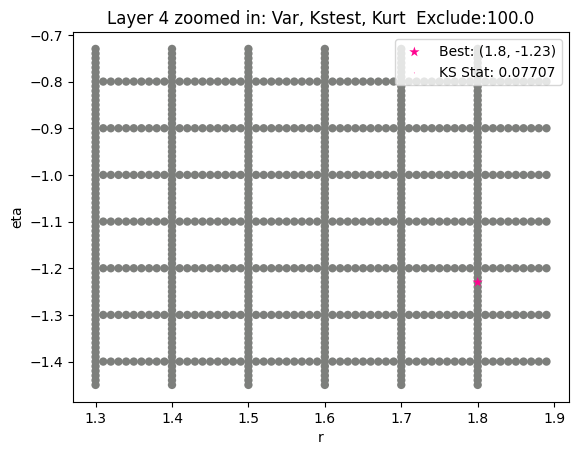

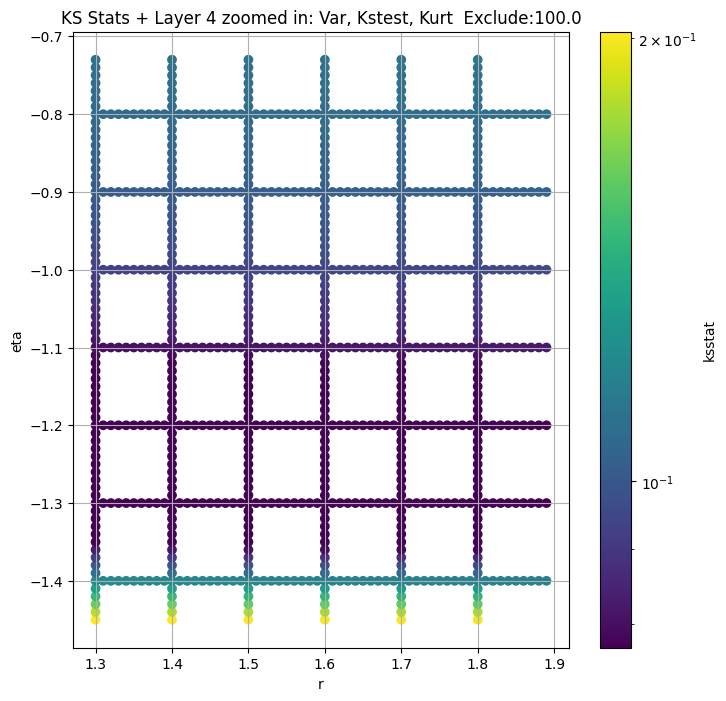

Layer 5


  0%|          | 0/113 [00:00<?, ?it/s]

Finding Minimum after computing 113 CDFs
layer 5, 0.0 + 100 = 100, ksstat: 0.04209999999999986, var: 406.2575988769531


  0%|          | 0/113 [00:00<?, ?it/s]

Finding Minimum after computing 113 CDFs
layer 5, 0.0 + 75 = 75, ksstat: 0.04209999999999986, var: 413.1693420410156


  0%|          | 0/113 [00:00<?, ?it/s]

Finding Minimum after computing 113 CDFs
layer 5, 0.0 + 50 = 50, ksstat: 0.04209999999999986, var: 421.08929443359375


  0%|          | 0/113 [00:00<?, ?it/s]

Finding Minimum after computing 113 CDFs
layer 5, 0.0 + 25 = 25, ksstat: 0.04209999999999986, var: 430.6728210449219


  0%|          | 0/113 [00:00<?, ?it/s]

Finding Minimum after computing 113 CDFs
layer 5, 0.0 + 0 = 0, ksstat: 0.04209999999999986, var: 447.8497314453125
Number of samples: 100000, Without approximation : 1149538.0


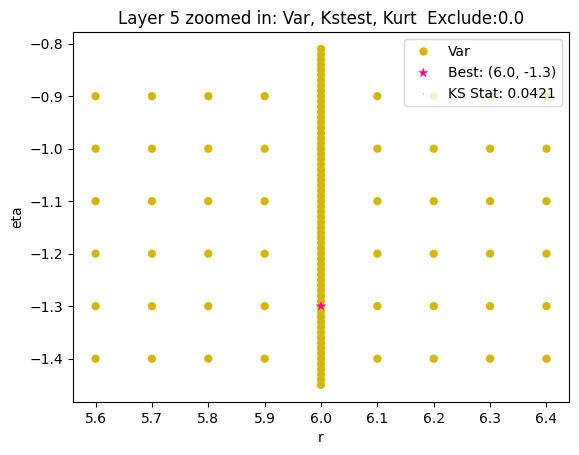

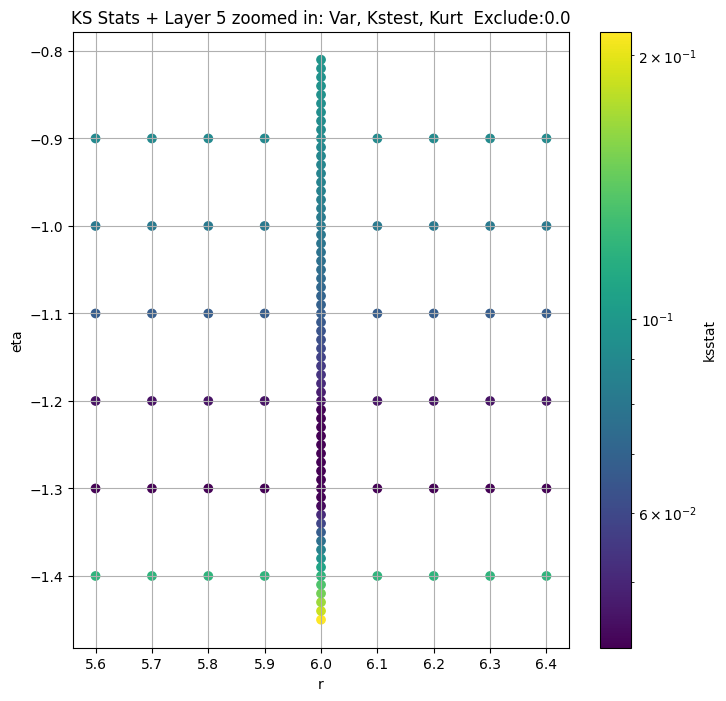

Layer 6


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 6, 0.0 + 100 = 100, ksstat: 0.014088562814388417, var: 96.79901123046875


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 6, 0.0 + 75 = 75, ksstat: 0.01315712092952026, var: 98.53750610351562


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 6, 0.0 + 50 = 50, ksstat: 0.012906647320128917, var: 100.54481506347656


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 6, 0.0 + 25 = 25, ksstat: 0.012659407986814863, var: 102.99363708496094


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 6, 0.0 + 0 = 0, ksstat: 0.01258762736286334, var: 107.2820816040039
Number of samples: 100000, Without approximation : 4251250.0


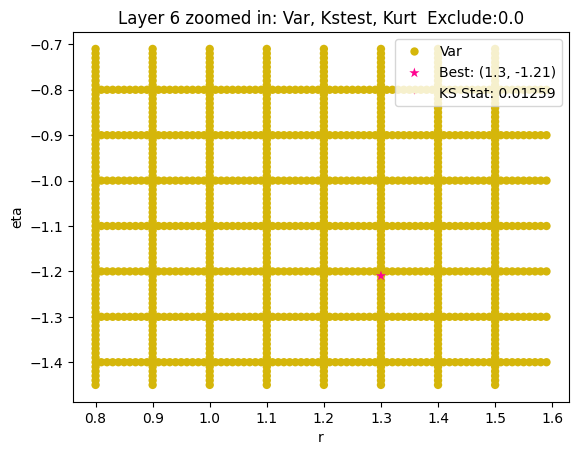

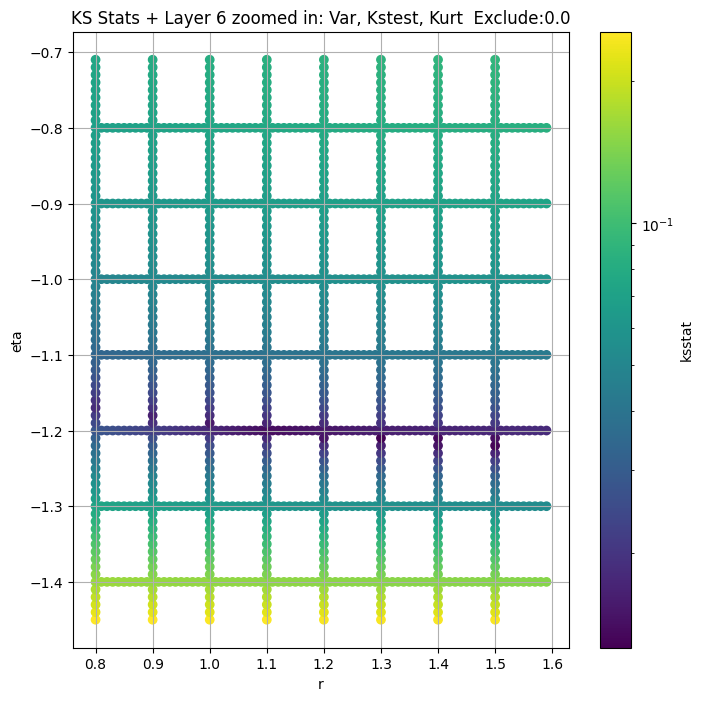

Layer 7


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 25.0 + 100 = 125, ksstat: 0.011884100810251763, var: 20.2381534576416


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 25.0 + 75 = 100, ksstat: 0.011725437997503585, var: 20.639251708984375


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 25.0 + 50 = 75, ksstat: 0.012010188328296784, var: 21.091352462768555


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 25.0 + 25 = 50, ksstat: 0.01159039794994765, var: 21.620450973510742


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 25.0 + 0 = 25, ksstat: 0.012410000652387398, var: 22.282089233398438


  0%|          | 0/1305 [00:00<?, ?it/s]

Finding Minimum after computing 1305 CDFs
layer 7, 25.0 + -25 = 0, ksstat: 0.012207113468033937, var: 23.563640594482422
Number of samples: 100000, Without approximation : 17005000.0


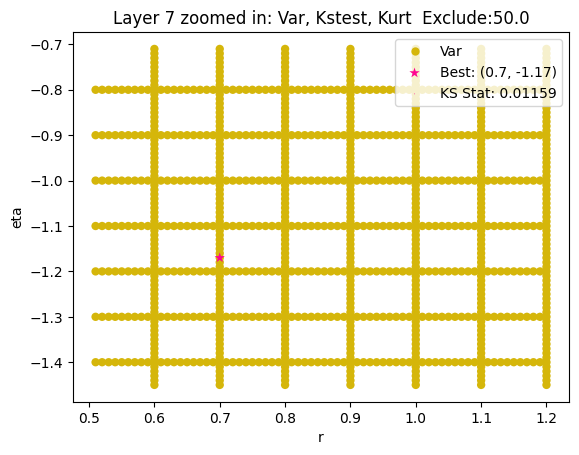

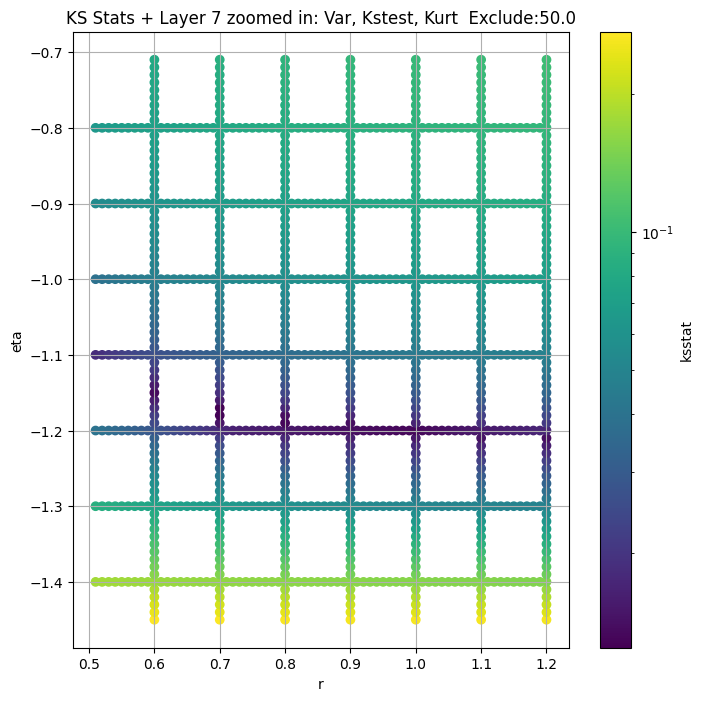

Layer 8


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
layer 8, 25.0 + 100 = 125, ksstat: 0.011931440092182943, var: 4.090367317199707


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
layer 8, 25.0 + 75 = 100, ksstat: 0.01127616326553671, var: 4.191810607910156


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
layer 8, 25.0 + 50 = 75, ksstat: 0.011366601107021493, var: 4.307834625244141


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
layer 8, 25.0 + 25 = 50, ksstat: 0.010784720001113746, var: 4.445937633514404


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
layer 8, 25.0 + 0 = 25, ksstat: 0.009946913843639743, var: 4.623250961303711


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
layer 8, 25.0 + -25 = 0, ksstat: 0.0100121189507002, var: 5.004115104675293
Number of samples: 100000, Without approximation : 68020000.0


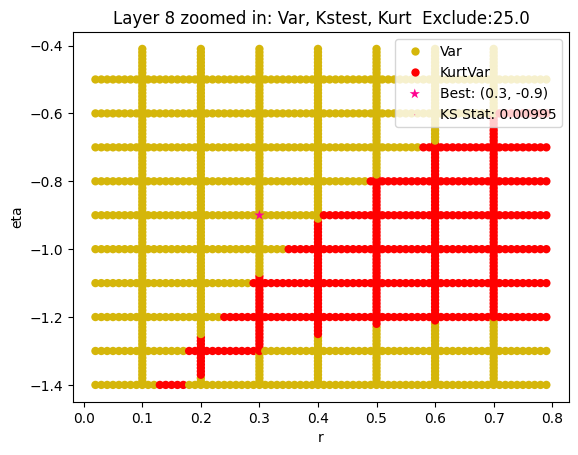

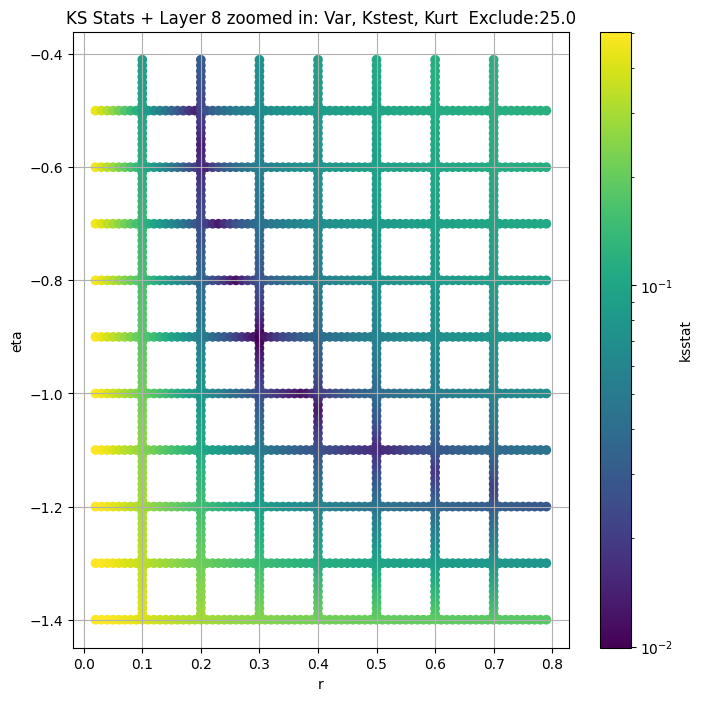

Layer 9


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 50.0 + 100 = 150, ksstat: 0.009057544197852194, var: 0.7003784775733948


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 50.0 + 75 = 125, ksstat: 0.008685433668038992, var: 0.7175121903419495


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 50.0 + 50 = 100, ksstat: 0.007996797514693912, var: 0.736852765083313


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 50.0 + 25 = 75, ksstat: 0.00729006678209683, var: 0.7592628002166748


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 50.0 + 0 = 50, ksstat: 0.0069029725403642606, var: 0.7864261269569397


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 50.0 + -25 = 25, ksstat: 0.0071108046969536876, var: 0.8224741816520691


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 50.0 + -50 = 0, ksstat: 0.007653357694290874, var: 0.9261622428894043
Number of samples: 100000, Without approximation : 272080000.0


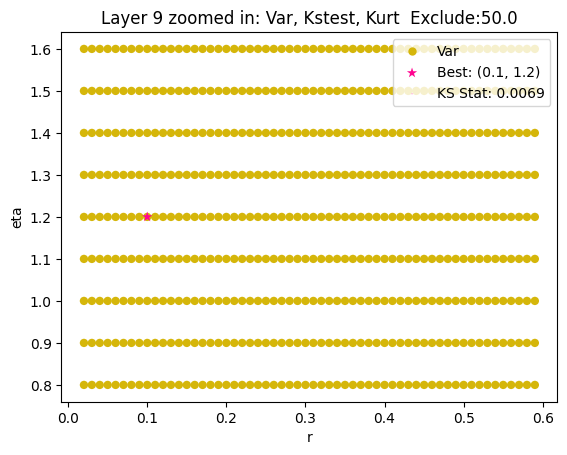

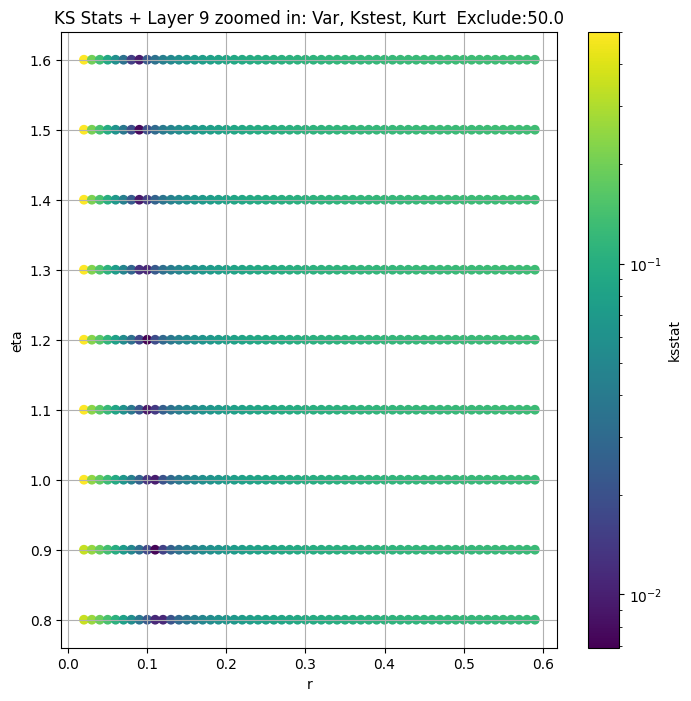

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff,n_pval_0.05
layer,,,,,,,,,,,,,,,,,,,,
2,18678.723000,17502.768000,19935.713000,4.316421,2.884981,6.461045,27208.0,0.012731,9.8,-1.0,5.310859e+04,50.0,16957.363000,0.008227,0.012731,9.8,-1.00,5.310859e+04,50.0,11478
3,5005.067000,4561.687500,5522.817000,11.798066,6.478199,25.282856,108832.0,0.132400,1.4,-1.2,2.040830e+04,0.0,4493.984375,0.004115,0.132400,1.8,-1.23,2.168066e+04,100.0,106
4,1581.170400,1451.115400,1726.020000,9.157448,6.194863,16.083818,333298.0,0.077070,1.4,-1.2,6.447267e+03,0.0,1436.246460,0.002352,0.077070,1.8,-1.23,6.928989e+03,100.0,306
5,447.849730,409.950100,492.390620,10.531361,6.367925,30.655203,1149538.0,0.042100,6.0,-1.3,2.873397e+03,0.0,447.849730,0.001267,0.042100,6.0,-1.30,2.873397e+03,0.0,1062
6,107.282080,98.076140,117.777664,10.588803,6.835792,22.530120,4251250.0,0.013962,1.1,-1.2,3.843363e+02,0.0,107.282082,0.000659,0.012588,1.3,-1.21,4.368114e+02,0.0,11820
7,23.563640,21.139654,26.704834,18.381596,9.488063,58.651060,17005000.0,0.012999,1.0,-1.2,7.427363e+01,25.0,21.620451,0.000329,0.011590,0.7,-1.17,4.223172e+01,50.0,14010
8,5.004115,4.364922,6.038305,36.424423,13.383648,160.152300,68020000.0,0.009947,0.3,-0.9,1.152098e-01,25.0,4.623251,0.000165,0.009947,0.3,-0.90,1.152098e-01,25.0,18681
9,0.926162,0.778725,1.294118,103.429955,15.216067,467.548800,272080000.0,0.006903,0.1,1.2,8.525931e-16,50.0,0.786426,0.000082,0.006903,0.1,1.20,8.525931e-16,50.0,37363


In [16]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

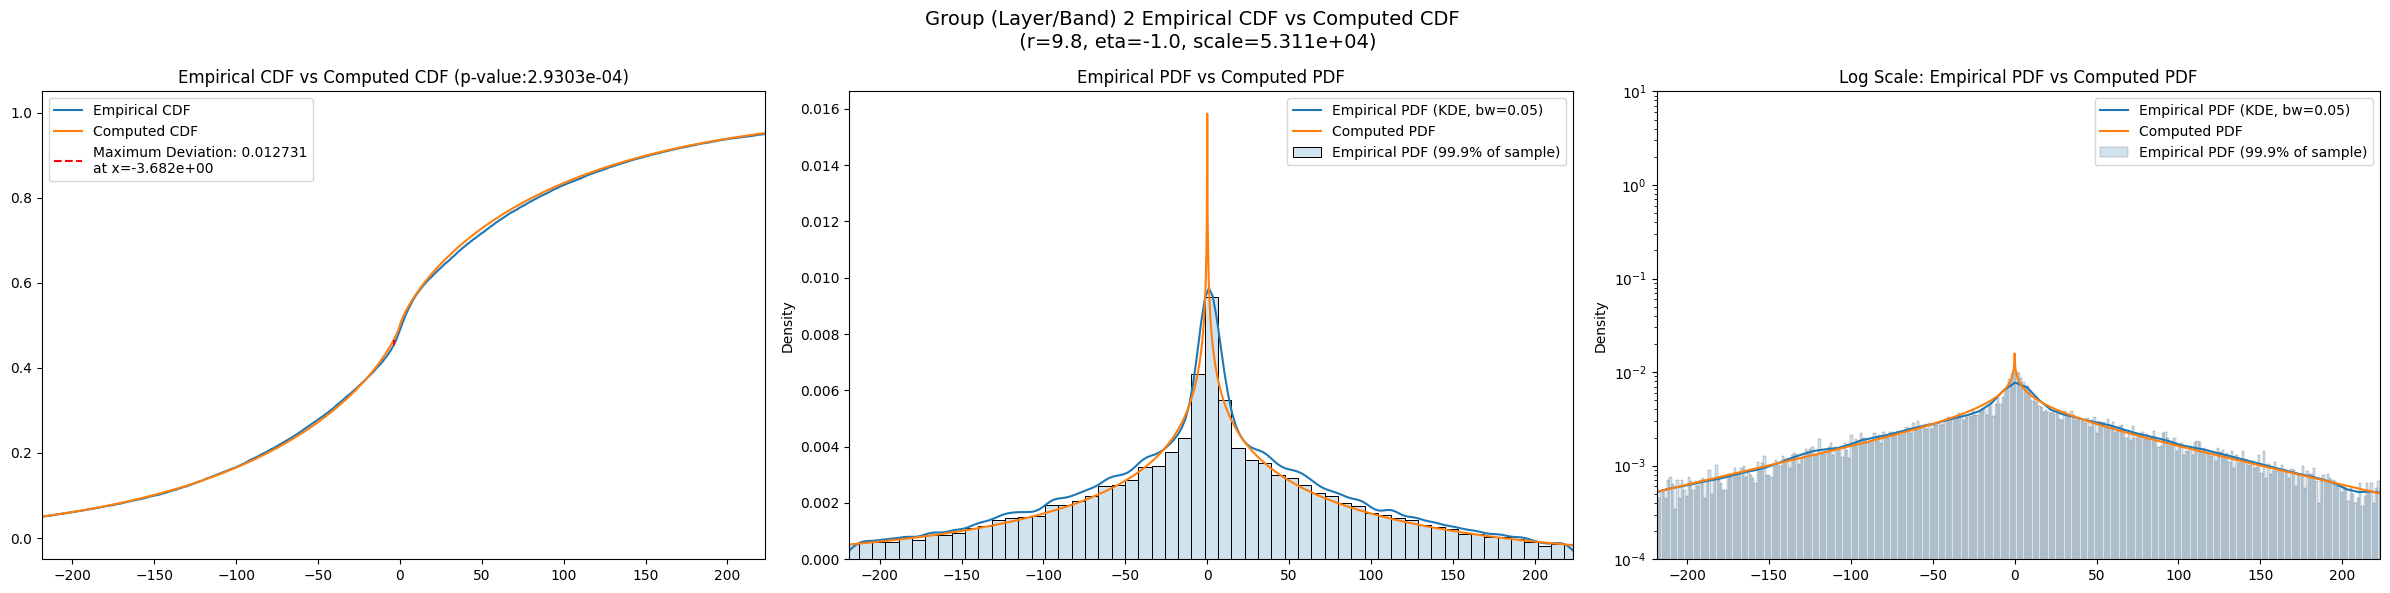

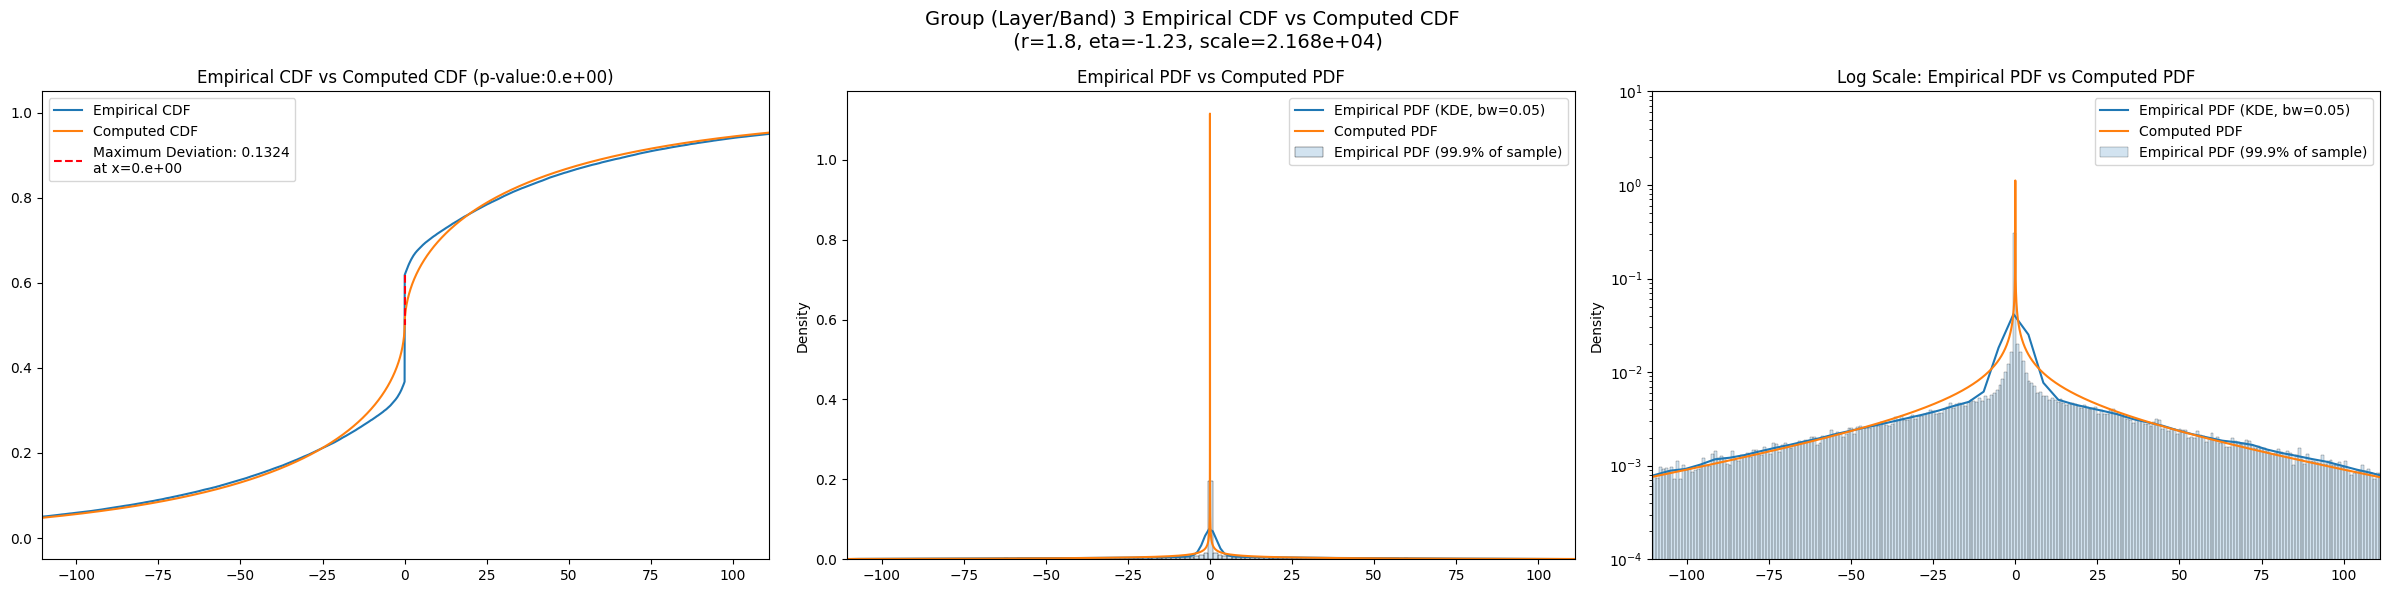

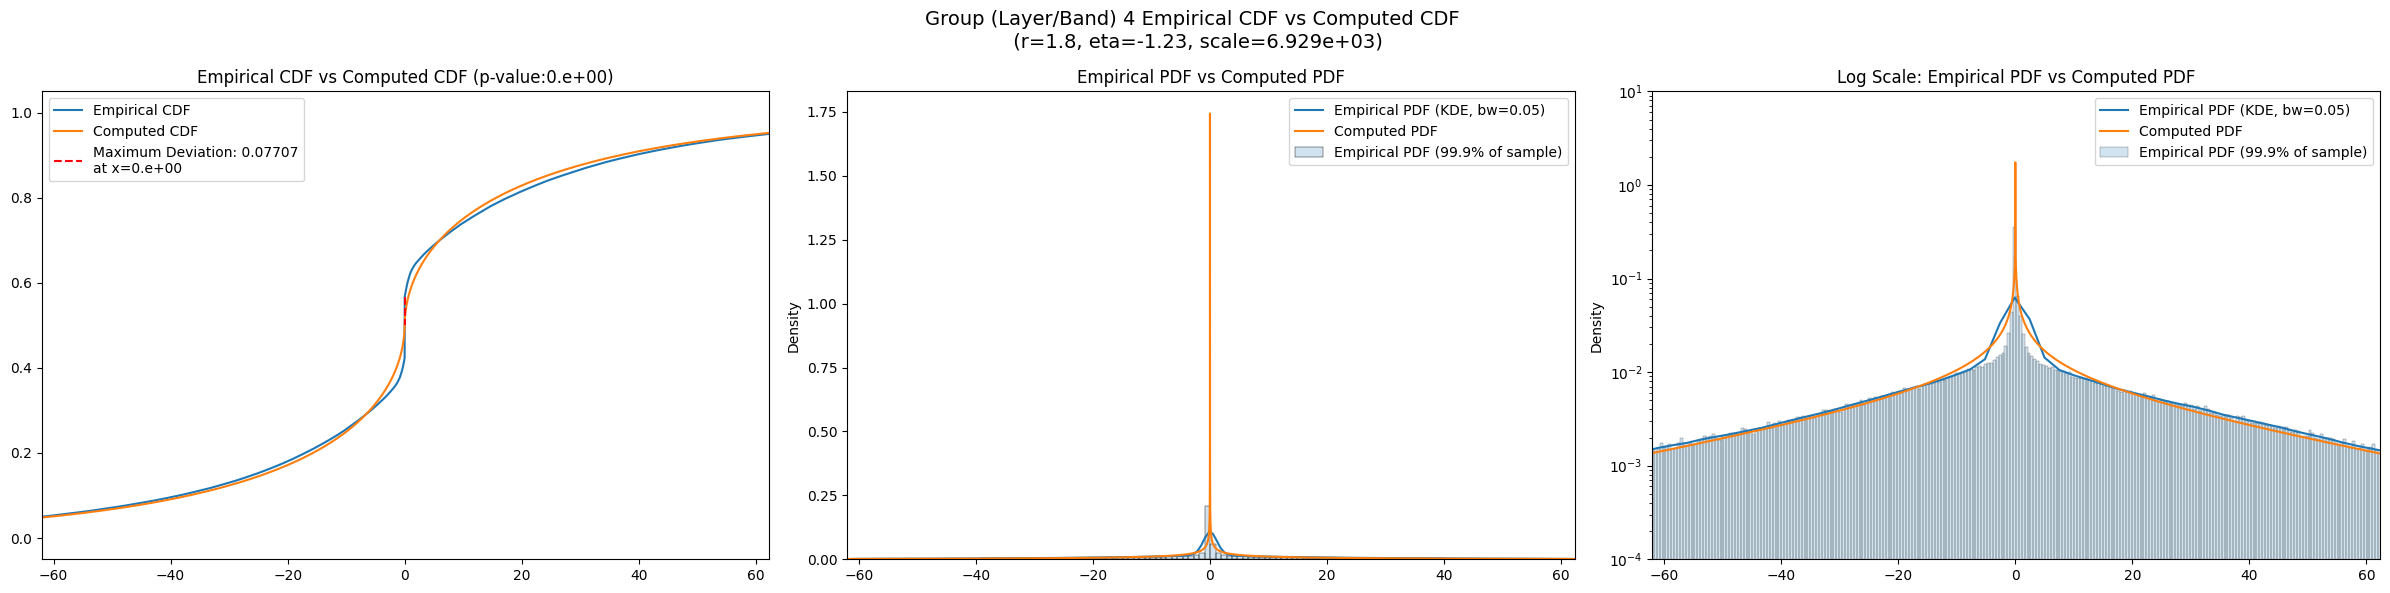

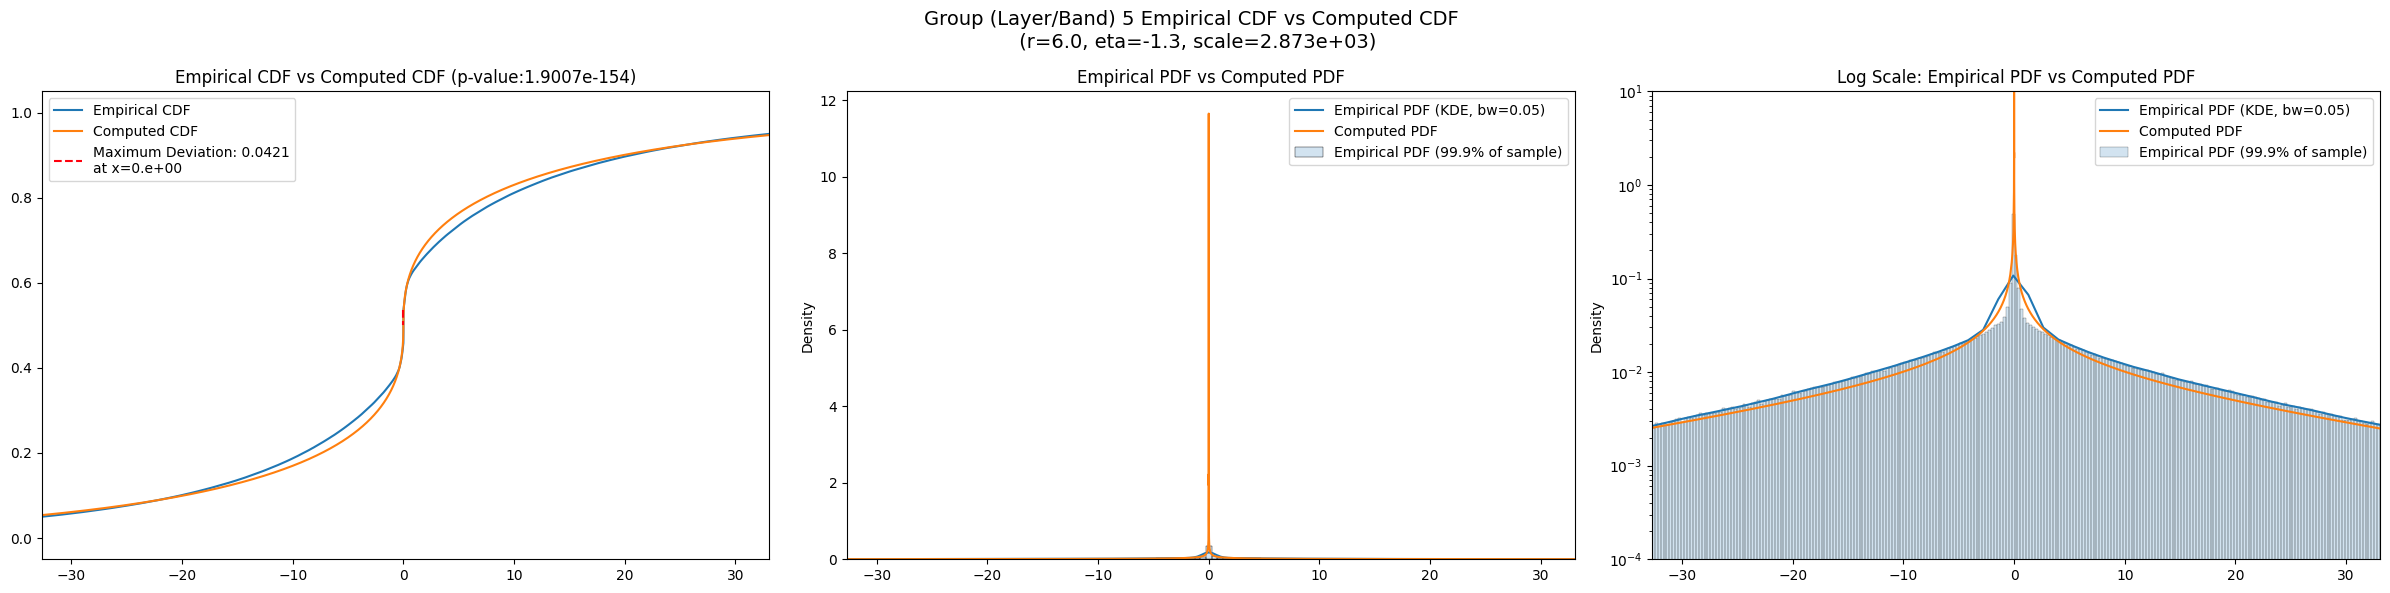

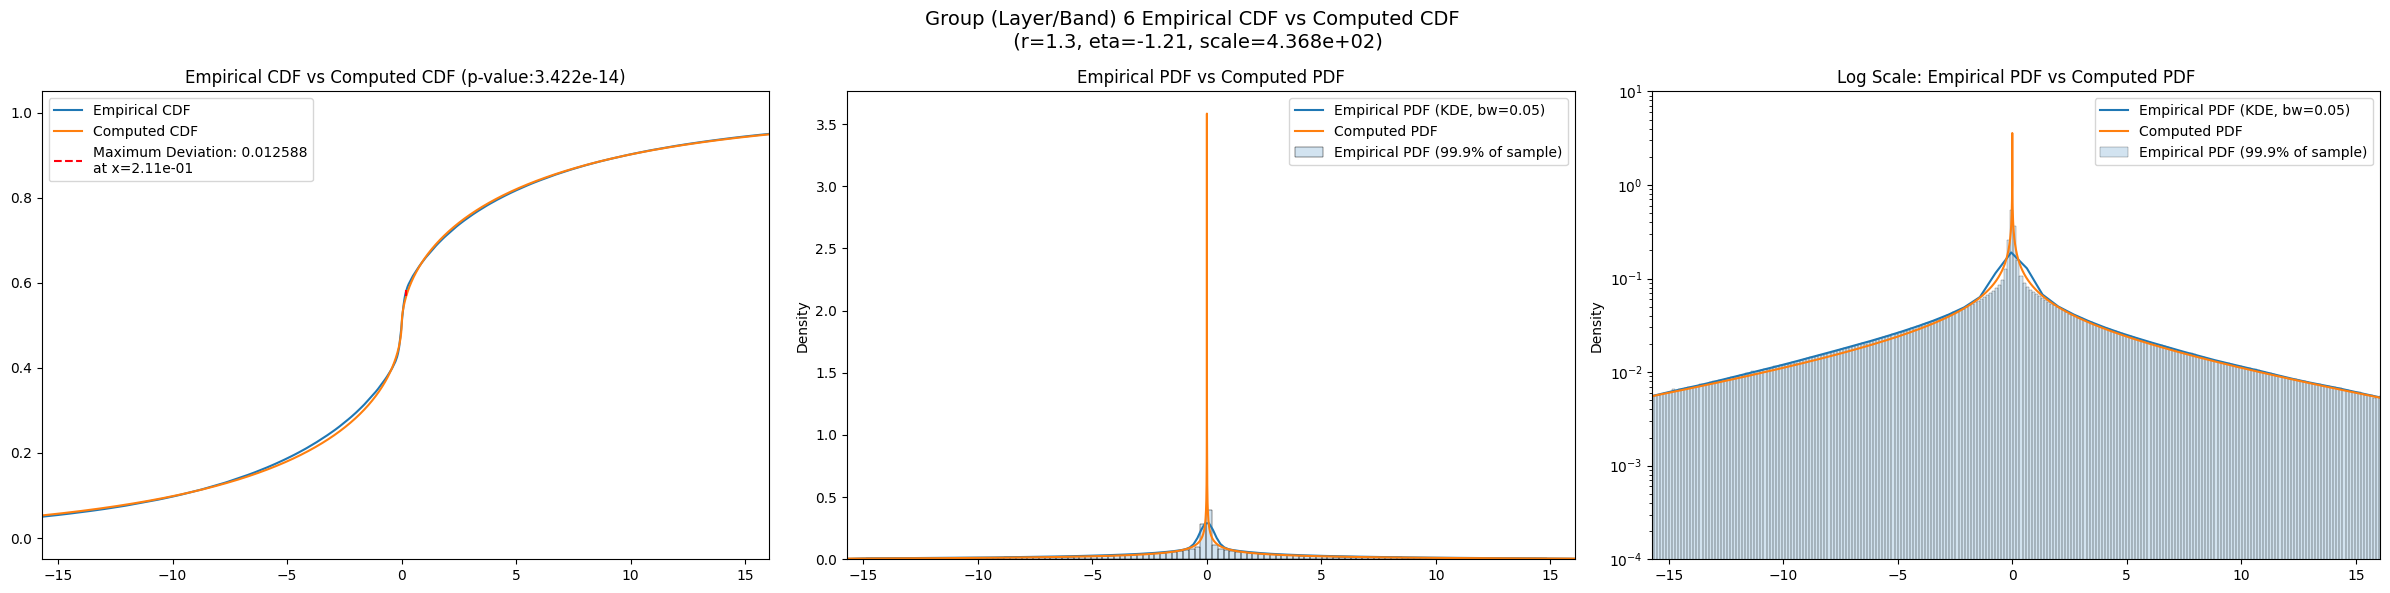

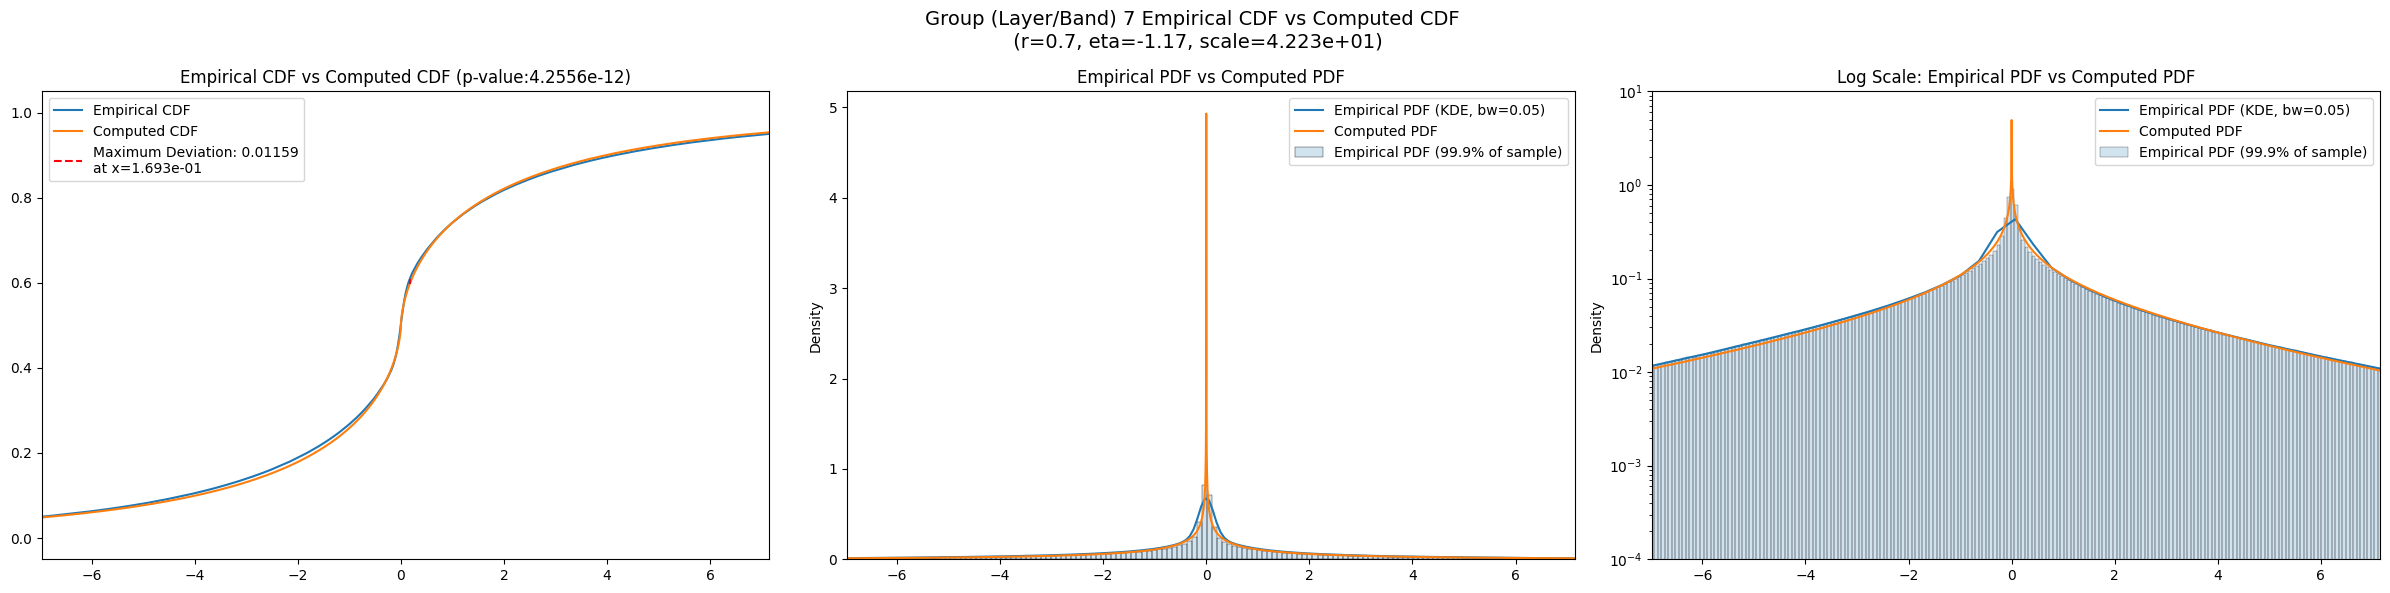

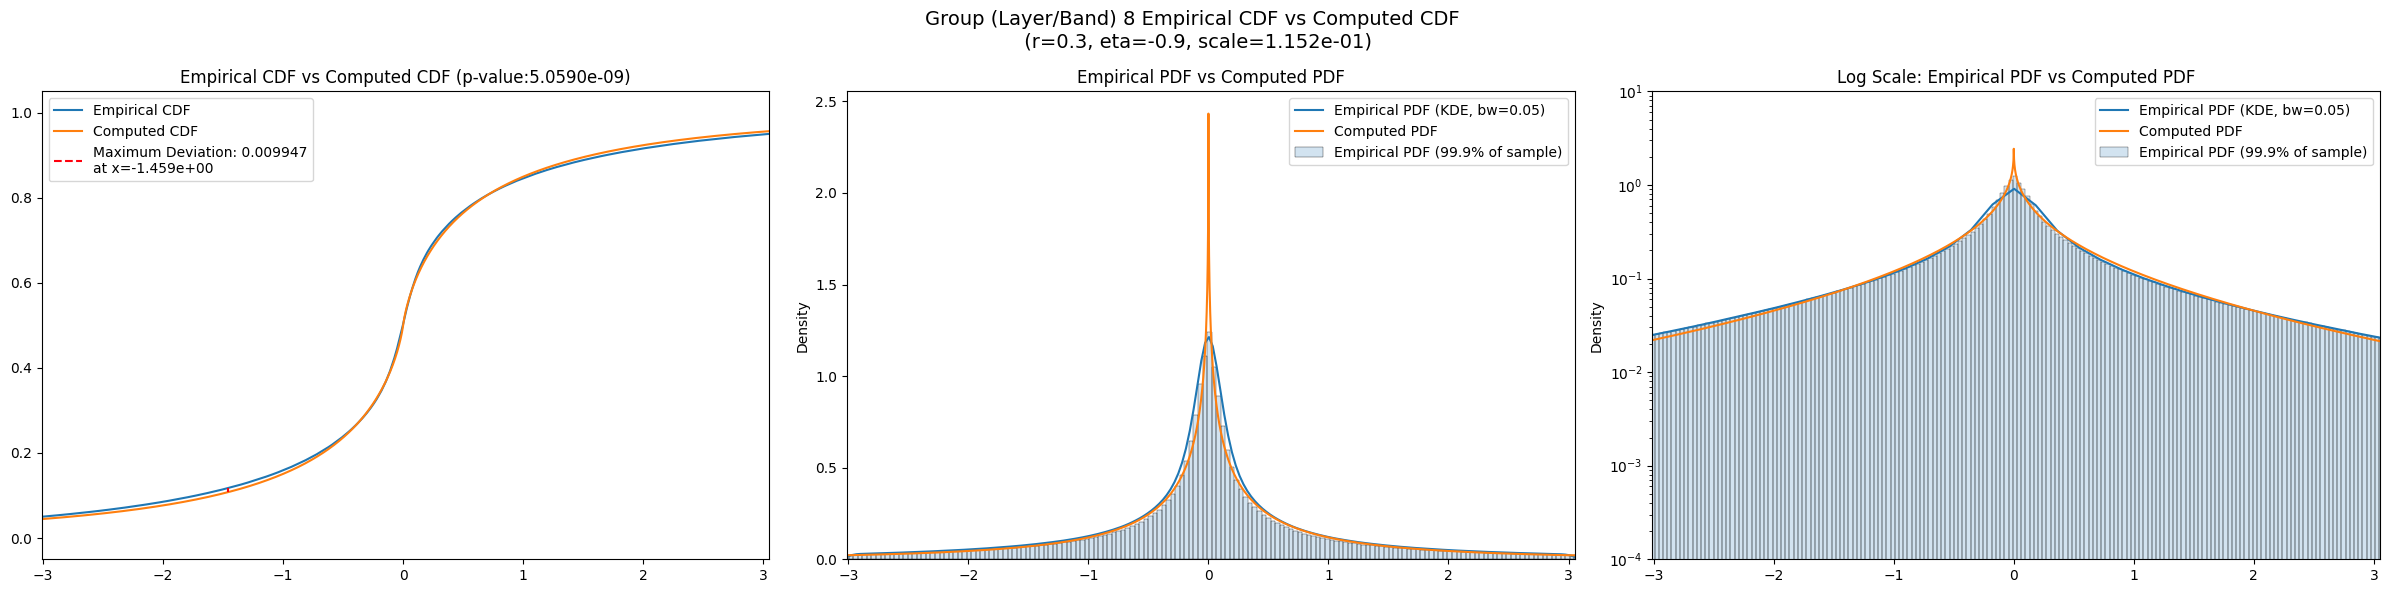

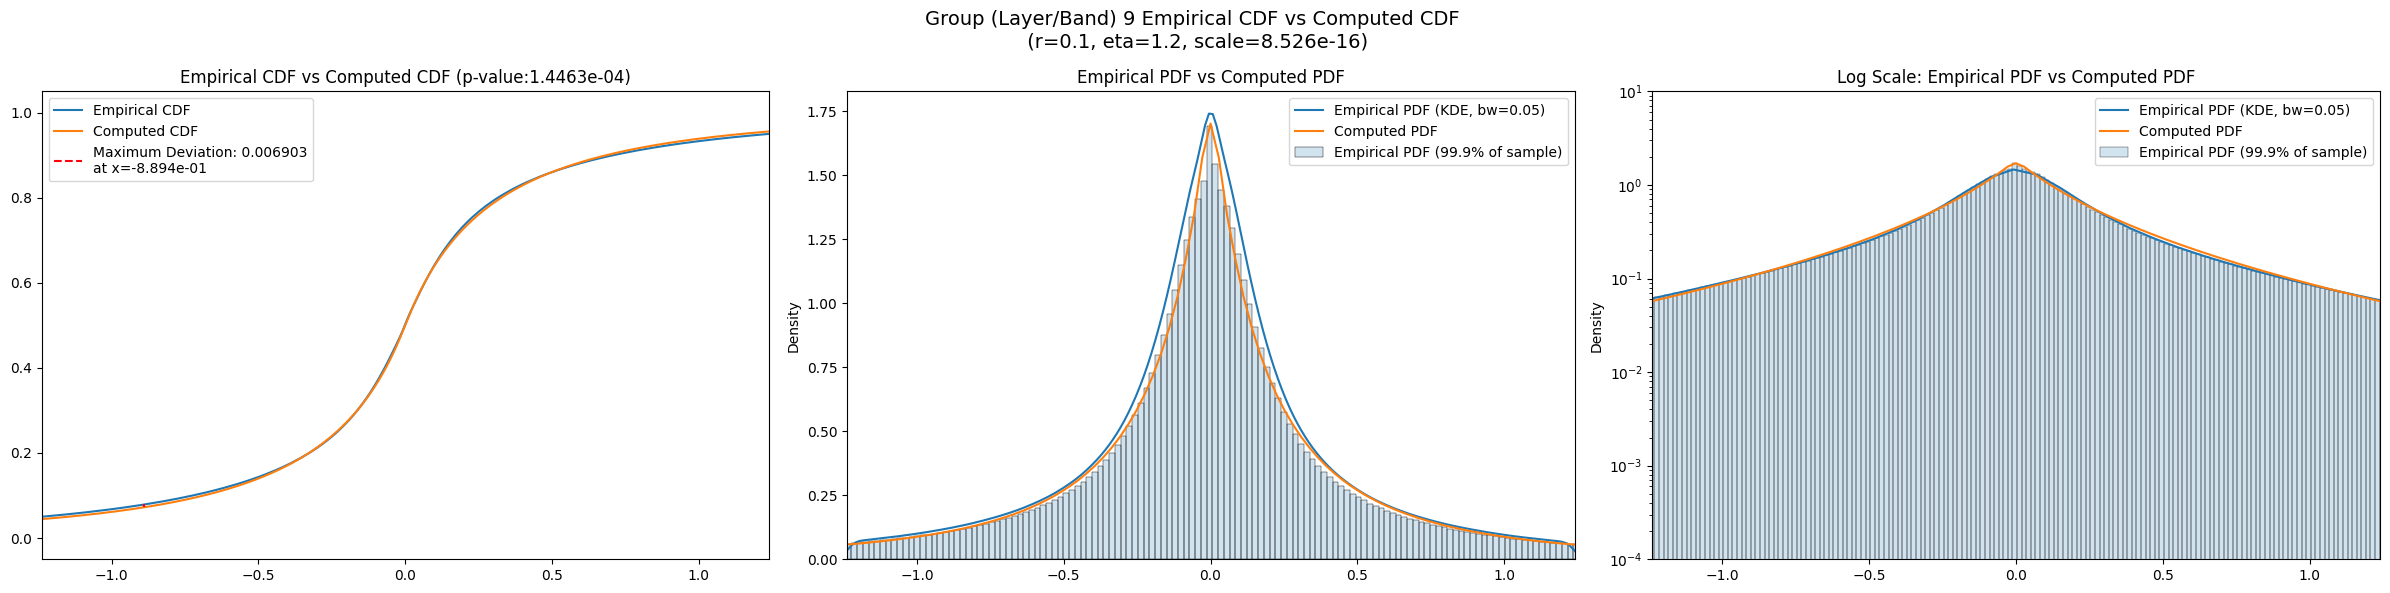

In [17]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [18]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [19]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
layer,,,,,,,,,,,,,,,,,,,,,
2,18678.723000,17502.768000,19935.713000,4.316421,2.884981,6.461045,27208.0,0.012731,9.8,-1.0,...,97.819500,0.044173,1.433140e-46,81.407500,0.026319,8.341260e-17,68.272100,0.031604,4.811890e-24,0.000293
3,5005.067000,4561.687500,5522.817000,11.798066,6.478199,25.282856,108832.0,0.132400,1.4,-1.2,...,21.695300,0.133634,0.000000e+00,15.605700,0.132400,0.000000e+00,12.120400,0.132400,0.000000e+00,0.000000
4,1581.170400,1451.115400,1726.020000,9.157448,6.194863,16.083818,333298.0,0.077070,1.4,-1.2,...,16.047100,0.103693,0.000000e+00,12.443100,0.090914,0.000000e+00,10.042600,0.093842,0.000000e+00,0.000000
5,447.849730,409.950100,492.390620,10.531361,6.367925,30.655203,1149538.0,0.042100,6.0,-1.3,...,9.328120,0.089759,0.000000e+00,7.243410,0.076215,0.000000e+00,5.830490,0.079115,0.000000e+00,0.000000
6,107.282080,98.076140,117.777664,10.588803,6.835792,22.530120,4251250.0,0.013962,1.1,-1.2,...,4.952320,0.076947,0.000000e+00,3.968520,0.059208,0.000000e+00,3.208240,0.062933,0.000000e+00,0.000000
7,23.563640,21.139654,26.704834,18.381596,9.488063,58.651060,17005000.0,0.012999,1.0,-1.2,...,2.014590,0.082244,0.000000e+00,1.661630,0.060853,0.000000e+00,1.319950,0.064315,0.000000e+00,0.000000
8,5.004115,4.364922,6.038305,36.424423,13.383648,160.152300,68020000.0,0.009947,0.3,-0.9,...,0.854379,0.078543,0.000000e+00,0.739736,0.052289,0.000000e+00,0.580964,0.053411,0.000000e+00,0.000000
9,0.926162,0.778725,1.294118,103.429955,15.216067,467.548800,272080000.0,0.006903,0.1,1.2,...,0.434080,0.058871,0.000000e+00,0.382434,0.031727,0.000000e+00,0.304734,0.030010,0.000000e+00,0.000000


## Results

In [20]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [21]:
master_df.filter(regex="kstest_stat.*")

,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_best,kstest_stat_gaussian,kstest_stat_laplace,kstest_stat_t
layer,,,,,,
2,0.012731,0.008227,0.012731,0.044173,0.026319,0.031604
3,0.132400,0.004115,0.132400,0.133634,0.132400,0.132400
4,0.077070,0.002352,0.077070,0.103693,0.090914,0.093842
5,0.042100,0.001267,0.042100,0.089759,0.076215,0.079115
6,0.013962,0.000659,0.012588,0.076947,0.059208,0.062933
7,0.012999,0.000329,0.011590,0.082244,0.060853,0.064315
8,0.009947,0.000165,0.009947,0.078543,0.052289,0.053411
9,0.006903,0.000082,0.006903,0.058871,0.031727,0.030010


In [22]:
master_df.filter(regex="best.*")

,best_augmented_var,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff
layer,,,,,,
2,16957.363000,0.012731,9.8,-1.00,5.310859e+04,50.0
3,4493.984375,0.132400,1.8,-1.23,2.168066e+04,100.0
4,1436.246460,0.077070,1.8,-1.23,6.928989e+03,100.0
5,447.849730,0.042100,6.0,-1.30,2.873397e+03,0.0
6,107.282082,0.012588,1.3,-1.21,4.368114e+02,0.0
7,21.620451,0.011590,0.7,-1.17,4.223172e+01,50.0
8,4.623251,0.009947,0.3,-0.90,1.152098e-01,25.0
9,0.786426,0.006903,0.1,1.20,8.525931e-16,50.0


In [23]:
eng.quit()